# EECE 5642 Data Visualization Midterm Project

In [1]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
import os
from os.path import join

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import math
%matplotlib inline

### Get All Files From 20_newsgroups Dataset

In [58]:
# define path for where 20_newsgroups is saved (I used slightly cleaned version from download options)
path = '/Users/alexsadler/Desktop/20news-18828/'

# get all files from all folders
all_files = []
for folder in os.listdir(path):
    for file in os.listdir(os.path.join(path, folder)):
        all_files.append((os.path.join(path, folder, file)))

        
# sample of files for testing (so don't have to process ~20,000 files)
files_sample = all_files[0:50]


## Part 1 - Preprocess Data

##### Cleaning Functions

In [7]:
stop_words = nltk.corpus.stopwords.words('english')
wl = WordNetLemmatizer()

def get_body_text(file_path):
    """Return body text of file path (skip headers)"""
    with open(file_path) as f:
        body = f.readlines()
        
    for line in range(len(body)):
        if body[line].endswith('writes:\n'):                
            idx_start = line + 1
            break
        # default start at 3 to skip first two header rows
        else:
            idx_start = 3
    
    body = body[idx_start:]         
    body = ' '.join(body)
    
    return body


def tokenize_clean_lem(file_data):
    """Return cleaned list of words from a given string"""
    # tokenize string from file
    tokens = nltk.tokenize.word_tokenize(file_data)
    # make all words lowercase
    words = [word.lower() for word in tokens]
    # remove tokens that aren't alphabetic
    words = [word for word in words if word.isalpha()]
    # remove stopwords
    words = [word for word in words if word not in stop_words]
    # lemmatize words
    words = [wl.lemmatize(word) for word in words]
    
    return words


##### Functions for Word Frequencies and Word/Sentence Extraction

In [21]:
def word_freq(files_list):
    """Return a list of words with number of total mentions for each word from a list of files"""
    all_words = []
    for file in files_list:
        # get body text from file
        file_content = get_body_text(file)
        # get tokenized, cleaned, and lemmatized list of words from file
        words = tokenize_clean_lem(file_content)

        for word in words:
            all_words.append(word)

    # return frequency of words from list of all words from all files    
    fdist_words_all_words = nltk.FreqDist(all_words)
    return fdist_words_all_words.most_common()


word_freq(files_sample)[:10]


[('armenian', 42),
 ('people', 28),
 ('right', 22),
 ('israeli', 18),
 ('israel', 15),
 ('used', 13),
 ('way', 13),
 ('word', 13),
 ('said', 12),
 ('name', 12)]

In [9]:
def doc_freq(files_list):
    """Return a list of words with number of mentions per document for each word from a list of files"""
    words_by_doc = []
    for file in files_list:
        # get body text from file        
        file_content = get_body_text(file)
        # get tokenized, cleaned, and lemmatized list of words from file
        words = tokenize_clean_lem(file_content)
        
        unique_words = list(set(words))
        for word in unique_words:
            words_by_doc.append(word)
    
    # return frequency of words from list of unique words for each file
    fdist_words_by_doc = nltk.FreqDist(words_by_doc)    
    return fdist_words_by_doc.most_common()


doc_freq(files_sample)[:10]


[('people', 7),
 ('said', 6),
 ('like', 5),
 ('would', 5),
 ('today', 5),
 ('way', 5),
 ('jewish', 4),
 ('israeli', 4),
 ('place', 4),
 ('government', 4)]

In [10]:
def sentences(files_list):
    """Return a list of all sentences from files in files_list"""
    all_sentences = []
    for file in files_list:
        # get body text from file
        file_content = get_body_text(file)
        # get rid of line breaks and split by sentence
        file_content = file_content.replace('\n','')    
        sentences = sent_tokenize(file_content)
        
        for sentence in sentences:
            all_sentences.append(sentence)
    
    # return all sentences from all files in files_list
    return all_sentences

sentences(files_sample)[:10]


['    Lebanese resistance forces detonated a bomb under an Israeli occupation    patrol in Lebanese territory two days ago.',
 'Three soldiers were killed and    two wounded.',
 'In "retaliation", Israeli and Israeli-backed forces wounded    8 civilians by bombarding several Lebanese villages.',
 'Ironically, the Israeli    government justifies its occupation in Lebanon by claiming that it is     necessary to prevent such bombardments of Israeli villages!!',
 'Congratulations to the brave men of the Lebanese resistance!',
 "With every    Israeli son that you place in the grave you are underlining the moral    bankruptcy of Israel's occupation and drawing attention to the Israeli    government's policy of reckless disregard for civilian life.",
 'Brad Hernlem (hernlem@chess.ncsu.EDU)  Very nice.',
 'Three people are murdered, and Bradly is overjoyed.',
 'When I hear about deaths in the middle east, be it Jewish or Arab deaths, I feel sadness, and only hope that soon this all stops.',
 '

## Part 2 - Bag of Words and TF-IDF

##### Bag of Words

In [11]:
def bag_of_words(files_list):
    """Return a term-document count matrix (matrix of # of occurences for each word where each column is a document)"""
    
    # get list of all words and list of word frequency vectors for each document
    all_words = []
    fdist_vectors = []
    for file in files_list:
        # get body text from file
        file_content = get_body_text(file)
        # get tokenized, cleaned, and lemmatized list of words from file
        words = tokenize_clean_lem(file_content)
        # get all words
        for word in words:
            all_words.append(word)
        
        # append frequency distribution of words for each document to fdist_vectors
        fdist_vectors.append(nltk.FreqDist(words))
    
    # get unique words and length of words
    all_words = list(set(all_words))
    len_vocab = len(all_words)
    
    
    # create vectors for each document with word frequency for each document for ALL words
    bag_vectors = []
    for vec in fdist_vectors:
        # initialize each bag of words vector to be zero vector with length of all_words
        bag_vector = np.zeros(len_vocab)
        for idx, word in enumerate(all_words):
            if word in vec:
                bag_vector[idx] = vec[word]
        bag_vectors.append(bag_vector)        
    df = pd.DataFrame(np.column_stack(bag_vectors), index=all_words).astype(int)
    
    return df


bag_of_words(files_sample).head(10)

,0,1,2,3,4,5,6,7,8,9
leo,0,0,1,0,0,0,0,0,0,0
neglecting,0,0,0,0,0,0,0,0,2,0
even,0,0,0,0,0,0,0,1,1,1
said,0,2,0,3,1,1,0,1,4,0
describe,0,0,0,0,0,0,0,0,0,1
illegitimate,0,0,0,0,0,0,0,0,2,0
whining,0,0,0,0,1,0,0,0,0,0
state,0,0,0,1,0,0,0,0,5,0
agains,0,0,0,0,1,0,0,0,0,0
road,0,0,0,0,0,0,0,1,0,1


##### TF-IDF
Calculating TF-IDF matrix with formula: weight = term_freq * log10(total number of docs / number of docs with term in it)

In [60]:
# convert bag of words matrix to binary term-document incidence matrix
bow_matrix = bag_of_words(files_sample)
tf_matrix = bag_of_words(files_sample)
tf_matrix[tf_matrix != 0] = 1

# get inverse document frequency
idf = np.log10(len(tf_matrix.columns)/tf_matrix.sum(axis=1))

# multiply bag of words matrix by frequency
bow_matrix.multiply(idf,axis=0).round(2).head()


,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
said,0.0,1.05,0.0,1.57,0.52,0.52,0.0,0.52,2.09,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
illegitimate,0.0,0.00,0.0,0.00,0.00,0.00,0.0,0.00,3.40,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
spent,0.0,0.00,0.0,0.00,0.00,0.00,0.0,0.00,0.00,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
coon,0.0,0.00,0.0,0.00,0.00,0.00,0.0,0.00,0.00,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
alec,0.0,0.00,0.0,0.00,0.00,0.00,0.0,0.00,0.00,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Data Visualization for Part 1

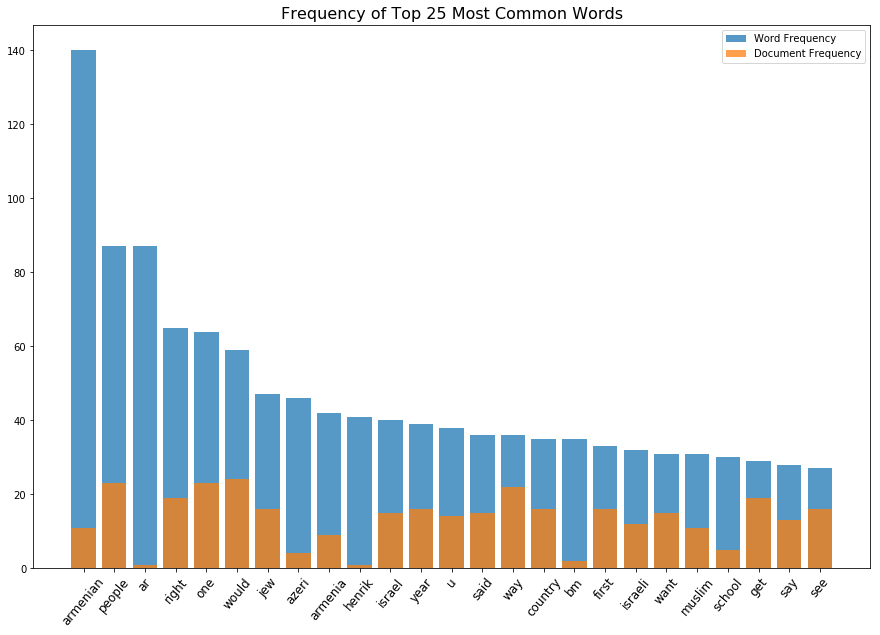

In [59]:
# get top n_top_words most frequent words across all documents
n_top_words = 25
word_freq_list = word_freq(files_sample)[:n_top_words]
terms_words, word_freqs = zip(*word_freq_list)

# get document frequency for all words
doc_freq_list = doc_freq(files_sample)
terms_docs, doc_freqs = zip(*doc_freq_list)

# find corresponding document frequency for each of most frequent words from all documents 
doc_freqs_list = []
for word in terms_words:
    idx = terms_docs.index(word)
    doc_freqs_list.append(doc_freqs[idx])

plt.figure(figsize=(15,10))
plt.title('Frequency of Top {} Most Common Words'.format(n_top_words),size=16)
plt.bar(range(n_top_words), word_freqs, align='center', tick_label=terms_words, alpha=0.75, label='Word Frequency')
plt.bar(range(n_top_words), doc_freqs_list, align='center', tick_label=terms_words, alpha=0.75, label='Document Frequency')
plt.xticks(rotation=50,size=12)
plt.legend()
plt.show()
